# OLED

Enter image name: OLED.png
Enter threshold: 230
Preview: 


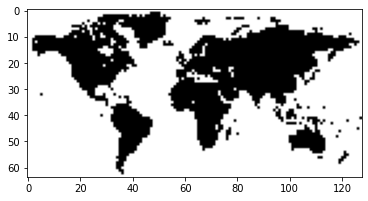

Program the FPGA? (Y/N): Y
(DEBUG) Profile path: /home/pj/.apio/profile.json
(DEBUG) Home_dir: /home/pj/.apio

PATH: /home/pj/.apio/packages/tools-oss-cad-suite/bin:/home/pj/.apio/packages/tools-oss-cad-suite/lib:/home/pj/.apio/packages/tools-system/bin:/home/pj/.apio/packages/toolchain-iverilog/bin:/home/pj/.apio/packages/toolchain-ice40/bin:/home/pj/.apio/packages/toolchain-yosys/bin:/home/pj/.apio/packages/tool-scons/script:/home/pj/bsc/bin:/opt/riscv/bin:/opt/ros/noetic/bin:/home/pj/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/pj/Desktop/PJ/microtesk-riscv-0.1.0-beta-191227/bin:/opt/riscv/bin:/home/pj/spike/bin:/home/pj/bsc/bin:/tools/Xilinx/Vivado/2020.2/bin:/tools/Xilinx/Vitis_HLS/2020.2/bin:/home/pj/Desktop/PJ/microtesk-riscv-0.1.0-beta-191227:/home/pj/Desktop/PJ/GitRepo/shakti-tools/bin:/home/pj/Desktop/PJ/GitRepo/shakti-tools/riscv32/bin:/home/pj/Desktop/PJ/GitRepo/shakti-tools/riscv32/riscv32-unknown-elf/b

In [1]:
import cv2
import matplotlib.pyplot as plt
import os

path=input("Enter image name: ")
thr=int(input("Enter threshold: "))

#read image
img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img=cv2.resize(img,(128,64))
img2=img.copy()

#convert image to binary image
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if(img[i,j]>thr):
            img[i,j]=255
            img2[i,j]=1
        else:
            img[i,j]=0
            img2[i,j]=0

#show processed image
print("Preview: ")
imgplot1 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#Open verilog file
Vfile = open("OLED.v","r+")              #Open OLED.v file in R+ (Read and write) mode
data = Vfile.read()                      #Read OLED module from the file
ptr = data.find("defparam Mem2.INIT_F")
Vfile.seek(ptr)                         #Place the pointer after OLED module

#write memory configuration
num=31
for k in range(0,8):
    for i in range(0,4):
        if(num>15):
            Vfile.write("defparam Mem2.INIT_{:01X} =256'h".format(num-16))  #BRAM2 initialization syntax
        else:
            Vfile.write("defparam Mem1.INIT_{:01X} =256'h".format(num))     #BRAM1 initialization syntax
        for j in range(32):
            b=img2[8*k:8*(k+1),(j+32*i)]                   #Slice 8*1 column from image
            zero_one = map(int, b)                         #Map the column to hex number
            n = int(''.join(map(str, zero_one)), 2)        #Append the hex number
            Vfile.write('{:02x}'.format(n))                 #Write the hex number in verilog file
        Vfile.write(";\n")
        num=num-1
Vfile.write('//------------------------------------------------------------------------------------------\n')
Vfile.write('endmodule')
Vfile.close()                                               #Close the verilog file

#Programming FPGA
pgm = input("Program the FPGA? (Y/N): ")
if(pgm.lower()=="y"):
    os.system('apio verify')
    os.system('apio build')
    os.system('apio upload')